# Общий ноутбук с полным решением продуктового анализа велопроката

## Команда

Название:

**Бигдатка**

Участники:
* **Калугин Константин** - Тимлид, ответственный за станции
* **Зейгман Константин** - Ответственный за байки
* **Муляр Никита** - Ответственный за целевую аудиторию

Ментор:

**Ермаков Егор**

## Предисловие

Необходимо разбить решение на следующие части:
1. Обработка сырого датасета, приведение всех данных к единому стандарту для более удобной работы и автоматизации вычислений с данными за все годы наблюдений
2. Разведочный анализ данных
3. Анализ велосипедов
4. Определение тенцендии изменения целевой аудитории
5. Анализ станций
6. Проанализировать экономику велопроката
7. Определить портрет целевой аудитории велопроката
8. Определить текущее состояние станций
9. Сделать выводы

Анализ датасета будет состоять из двух частей: выдвижение гипотезы и ее подтверждение (или опровержение, что тоже хорошо). Однако это не обязательное правило, часто мы будем просто пытаться узнать какую-то дополнительную информацию, чтобы уточнить некоторые экономически важные вопросы

## Решение

### Обработка датасета

#### Проблема

1. Таблицы за 2013-2019 года отличаются по присутствующим данным от таблиц за 2020-2022 год
2. В некоторых таблицах данные представлены с кавычками
3. В таблицах за 2013-2019 года некоторая информация о станциях находится в других файлах
4. В таблицах используется различных формат дат

#### Решение проблемы

Определяем библиотеки, которые будут задействованы для обработки датасета

In [4]:
from pyspark import SparkConf, SparkContext
import os
import datetime
import shutil
import pandas as pd
import numpy as np
import requests
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
from math import floor

Определяем функции, которые будут задествованы для стандартизации записи данных

In [5]:
def filter_first_2013_2019(line):
    try:
        first_elem = int(line[0])
        return True
    except:
        return False


def filter_first_2020_2023(line):
    if line[0] == 'ride_id':
        return False
    return True


def del_quotation_marks(elems):
    for i in range(len(elems)):
        if '"' in elems[i]:
            elems[i] = elems[i][1:-1]
    return elems


def map_2013_2019(elems):
    try:
        if '/' not in elems[1]:
            if len(elems[1].split()[1]) != 8:
                return ','.join([elems[0], '', datetime.datetime.strptime(elems[1], "%Y-%m-%d %H:%M").isoformat(),
                                 datetime.datetime.strptime(elems[2], "%Y-%m-%d %H:%M").isoformat(), elems[-6],
                                 elems[-4], '', '', '', '', elems[-3], elems[-2],
                                 str(datetime.datetime.strptime(elems[1], "%Y-%m-%d %H:%M").year - int(elems[-1])) if elems[-1] else '', elems[3]])
            else:
                return ','.join([elems[0], '', datetime.datetime.strptime(elems[1], "%Y-%m-%d %H:%M:%S").isoformat(),
                                 datetime.datetime.strptime(elems[2], "%Y-%m-%d %H:%M:%S").isoformat(), elems[-6],
                                 elems[-4], '', '', '', '', elems[-3], elems[-2],
                                 str(datetime.datetime.strptime(elems[1], "%Y-%m-%d %H:%M:%S").year - int(elems[-1])) if elems[-1] else '', elems[3]])
        else:
            if elems[1][-3] == ':' and elems[1][-6] == ':':
                return ','.join([elems[0], '', datetime.datetime.strptime(elems[1], "%m/%d/%Y %H:%M:%S").isoformat(),
                                 datetime.datetime.strptime(elems[2], "%m/%d/%Y %H:%M:%S").isoformat(), elems[-6],
                                 elems[-4], '', '', '', '', elems[-3], elems[-2],
                                 str(datetime.datetime.strptime(elems[1], "%m/%d/%Y %H:%M:%S").year - int(elems[-1])) if elems[-1] else '', elems[3]])
            else:
                return ','.join([elems[0], '', datetime.datetime.strptime(elems[1], "%m/%d/%Y %H:%M").isoformat(),
                             datetime.datetime.strptime(elems[2], "%m/%d/%Y %H:%M").isoformat(), elems[-6],
                             elems[-4], '', '', '', '', elems[-3], elems[-2],
                             str(datetime.datetime.strptime(elems[1], "%m/%d/%Y %H:%M").year - int(elems[-1])) if elems[-1] else '', elems[3]])
    except:
        return ''


def map_2020_2023(elems):
     try:
        return ','.join([elems[0], elems[1], datetime.datetime.strptime(elems[2], "%Y-%m-%d %H:%M:%S").isoformat(),
                         datetime.datetime.strptime(elems[3], "%Y-%m-%d %H:%M:%S").isoformat(),
                         elems[4], elems[6], elems[8], elems[9],
                         elems[10], elems[11], elems[12], '', '', ''])
     except:
         return ''

Определяем функции, которые будут задействованы для получения координат станций (требуется для 2013-2019 годов)

In [6]:
def mapper_st(line):
    info = line.split(",")
    if info[0].isnumeric() and info[1] != "" and info[2] != "" and info[3] != "":
        yield (info[0], (info[1], info[2], info[3]))

def mapper_tr(line):
    id_, type_, started_at, ended_at, start_name, end_name, start_lat, start_lng, end_lat, end_lng, member_casul, gender, age, bikeid = line.split(",")
    return {
        "id": int(id_),
        "type": type_,
        "started_at": started_at,
        "ended_at": ended_at,
        "start_name": start_name,
        "end_name": end_name,
        "member_casul": member_casul,
        "gender": gender,
        "age": age,
        "bikeid": bikeid
    }

def mapper_inter(line):
    from_name, (data, station) = line
    return {
        "id": data["id"],
        "type": data["type"],
        "started_at": data["started_at"],
        "ended_at": data["ended_at"],
        "start_name": data["start_name"],
        "end_name": data["end_name"],
        "start_lat": station["latitude"] if station else "",
        "start_lng": station["longitude"] if station else "",
        "member_casul": data["member_casul"],
        "gender": data["gender"],
        "age": data["age"],
        "bikeid": data["bikeid"]
    }

def mapper_st_final(x):
    return {
        "name": x[1][0],
        "latitude": x[1][1],
        "longitude": x[1][2]
    }

def finalise(line):
    to_name, (data, station) = line
    return ",".join([str(x) for x in [
        data["id"],
        data["type"],
        data["started_at"],
        data["ended_at"],
        data["start_name"],
        data["end_name"],
        data["start_lat"],
        data["start_lng"],
        station["latitude"] if station else "",
        station["longitude"] if station else "",
        data["member_casul"],
        data["gender"],
        data["age"],
        data["bikeid"]
    ]])


Определяем функцию, которая реализует описанные выше функции для стандартизации

In [7]:
def get_data():
    directory ='sources/'
    # 2013 - 2019
    for i in range(2013, 2020):
        files = None
        try:
            for filename in os.listdir(directory):
                if str(i) not in filename:
                    continue
                file = sc.textFile(os.path.join(directory, filename)) \
                    .map(lambda line: line.split(',')) \
                    .map(del_quotation_marks) \
                    .filter(filter_first_2013_2019)
                if files is None:
                    files = file
                else:
                    files = files.union(file)
            res = files.map(map_2013_2019).filter(lambda x: x != '')
            res.coalesce(1).saveAsTextFile(f'clean_sources/{i}')
        except:
            pass
    # 2020 - 2023
    for i in range(2020, 2024):
        files = None
        try:
            for filename in os.listdir(directory):
                if str(i) not in filename:
                    continue
                file = sc.textFile(os.path.join(directory, filename)) \
                    .map(lambda line: line.split(',')) \
                    .map(del_quotation_marks) \
                    .filter(filter_first_2020_2023)
                if files is None:
                    files = file
                else:
                    files = files.union(file)
            res = files.map(map_2020_2023).filter(lambda x: x != '')
            res.coalesce(1).saveAsTextFile(f'clean_sources/{i}')
        except:
            pass

Определяем цункцию, которая будет использоваться для получения координат и добавления ее к датасету

In [8]:
def bind_data():
    # собрать данные о станциях
    stations = sc.textFile("stations").flatMap(mapper_st) \
                                      .reduceByKey(lambda a, b: a) \
                                      .map(mapper_st_final)
    stations_key = stations.keyBy(lambda x: x["name"])
    for y in range(2013, 2019 + 1):
        try:
            df = sc.textFile(f"clean_sources/{y}").map(mapper_tr)
            df_from = df.keyBy(lambda x: x["start_name"])
            inter = df_from.leftOuterJoin(stations_key) \
                .map(mapper_inter)
            df_to = inter.keyBy(lambda x: x["end_name"])
            final = df_to.leftOuterJoin(stations_key) \
                .map(finalise) \
                .coalesce(1) \
                .saveAsTextFile(f"binded_data/{y}")
        except:
            pass

Собираем все полученные таблицы в одной папке, остальные удаляем

In [9]:
def unity():
    os.makedirs('data/src')
    for i in range(2013, 2020):
        os.rename(f'binded_data/{i}', f'data/src/{i}')
    for i in range(2020, 2024):
        os.rename(f'clean_sources/{i}', f'data/src/{i}')
    shutil.rmtree('binded_data')
    shutil.rmtree('clean_sources')

Запускаем обработку данных

In [ ]:
conf = SparkConf().setAppName('test').setMaster('local')
sc = SparkContext(conf=conf)

In [12]:
get_data()
bind_data()
unity()

В итоге мы оставляем следующие колонки:
1. id - уникальный идентификатор поездки
2. biketype - тип велосипеда
3. starttime - время начала поездки
4. endtime - время окончания поездки
5. startstation - название стартовой станции
6. endstation- название конечной станции
7. startlat, startlng - координаты стартовой станции
8. endlat, endlng - координаты конечной станции
9. member_casual - тип пользователя
10. age - возраст пользователя
11. gender - пол пользователя
12. bikeid - уникальный идентификатор велосипеда

### Разведочный анализ

#### Цели

1. Определить основные направления исследований
2. Определить какая информация может отсутствовать в различные временные интервалы
3. Определить, какие временные интервалы подходят под те или иные направления

#### Достижение цели

Посмотрим, как выглядят данные за различные годы

In [13]:
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    print(year)
    print(df.head())
    print()

2013
       id  biketype            starttime              endtime  \
0  126212       NaN  2013-07-29T19:03:00  2013-07-29T19:21:00   
1  153535       NaN  2013-08-04T00:22:00  2013-08-04T00:46:00   
2   74162       NaN  2013-07-17T23:45:00  2013-07-18T00:09:00   
3  572092       NaN  2013-09-23T19:58:00  2013-09-23T20:24:00   
4   71712       NaN  2013-07-17T09:53:00  2013-07-17T10:18:00   

                    startstation                endstation startlat  \
0  Sheffield Ave & Fullerton Ave  Aberdeen St & Madison St  Chicago   
1  Sheffield Ave & Fullerton Ave  Aberdeen St & Madison St  Chicago   
2  Sheffield Ave & Fullerton Ave  Aberdeen St & Madison St  Chicago   
3  Sheffield Ave & Fullerton Ave  Aberdeen St & Madison St  Chicago   
4             State St & 16th St  Aberdeen St & Madison St      NaN   

    startlng endlat  endlng member_casual gender   age  bikeid  
0  41.925602    NaN     NaN      Customer    NaN   NaN     847  
1  41.925602    NaN     NaN      Customer    Na

2020
                 id       biketype            starttime              endtime  \
0  BD0A6FF6FFF9B921  electric_bike  2020-11-01T13:36:00  2020-11-01T13:45:40   
1  96A7A7A4BDE4F82D  electric_bike  2020-11-01T10:03:26  2020-11-01T10:14:45   
2  C61526D06582BDC5  electric_bike  2020-11-01T00:34:05  2020-11-01T01:03:06   
3  E533E89C32080B9E  electric_bike  2020-11-01T00:45:16  2020-11-01T00:54:31   
4  1C9F4EF18C168C60  electric_bike  2020-11-01T15:43:25  2020-11-01T16:16:52   

                startstation                endstation   startlat   startlng  \
0      Dearborn St & Erie St    St. Clair St & Erie St  41.894177 -87.629127   
1  Franklin St & Illinois St  Noble St & Milwaukee Ave  41.890959 -87.635343   
2  Lake Shore Dr & Monroe St      Federal St & Polk St  41.880983 -87.616754   
3   Leavitt St & Chicago Ave   Stave St & Armitage Ave  41.895499 -87.682013   
4        Buckingham Fountain       Buckingham Fountain  41.876497 -87.620358   

      endlat     endlng member_ca

Заметим, что помимо очевидных пропусков в данных за различные периоды, можно заметить, что члены и нечлены помечаются по-разному.

Проверим это ниже

In [14]:
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    print(year)
    print(df['member_casual'].unique())
    print()

2013
['Customer' 'Subscriber']

2014
['Subscriber' 'Customer']

2015
['Customer' 'Subscriber' 'Dependent']

2016
['Subscriber' 'Customer' 'Dependent']

2017
['Subscriber' 'Customer' 'Dependent']

2018
['Subscriber' 'Customer']

2019
['Subscriber' 'Customer']

2020
['casual' 'member']

2021
['casual' 'member']

2022
['casual' 'member']

2023
['member' 'casual']



Члены могут быть отмечены в логах как "member" или как "Subscriber", а нечлены - как "Customer" или как "casual". Также иногда встречается "Depended", но он не представляет для нас никакого интереса в конечном счете

Определим, как менялось с годами количество станций

In [15]:
counts_stations = []
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    counts_stations.append(len(np.unique(np.concatenate((df['startstation'].dropna().unique(), df['endstation'].dropna().unique()), axis=None))))

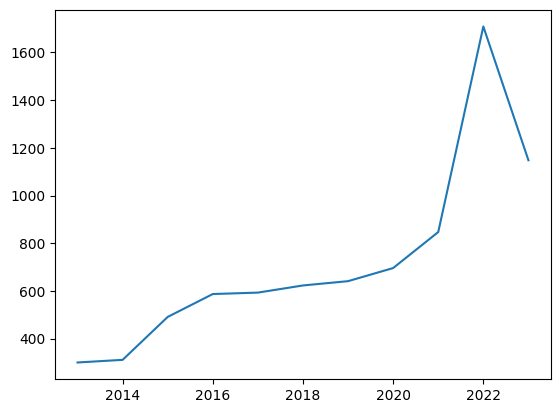

In [16]:
plt.plot(range(2013, 2024), counts_stations)
plt.xlabel('Годы')
plt.ylabel('Количество станций')
plt.title('Динамическое изменение количества станций')

Как мы видим по графику, количество станций растет. Падение в конце же обусловлено тем, что мы имеем за последний год только 3 месяца, вместо 12, из-за было собрано мало данных

Однако именно на информации за 2023 мы будем основываться в анализе станций, т.к. только с ними мы можем иметь высокую уверенность в том, что станции не были закрыты (к тому же по выборка достаточно большая, что делает ее репрезентативной)

Посмотрим на то, как могут строиться маршруты

In [17]:
df = pd.read_table(f'data/src/2023/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')

In [18]:
stations = df[['startstation', 'endstation']]
stations.rename(columns={'startstation': 'source', 'endstation': 'target'})
graph = nx.Graph()
graph.add_edges_from(stations.to_numpy())

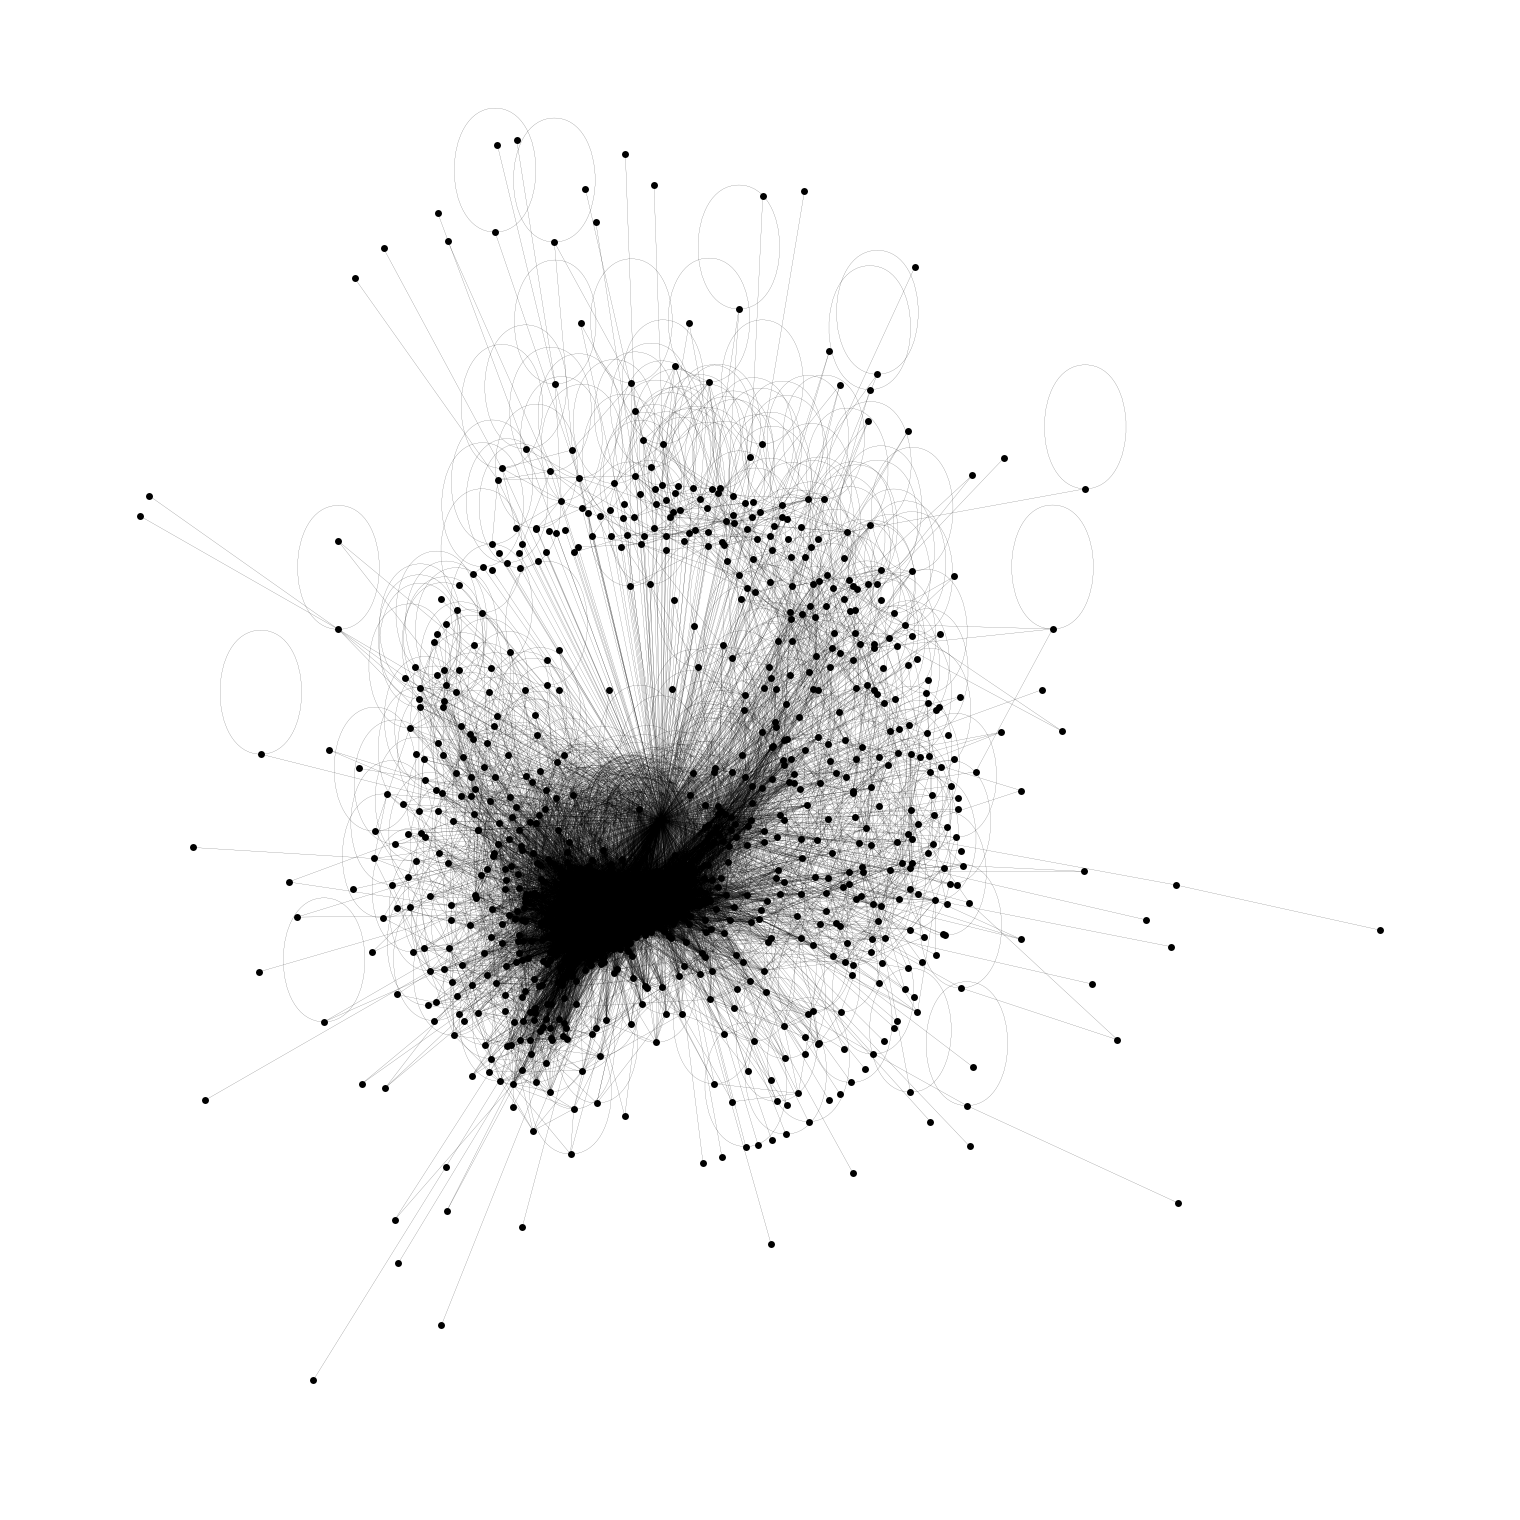

In [20]:
plt.figure(figsize=(15,15))
options = {"node_color": "black", "node_size": 25, "linewidths": 0, "width": 0.1}
pos = nx.spring_layout(graph, seed=1969)
nx.draw(graph, pos, **options)

Как мы видим, в логгах встречаются прогулочные сессии (т.е. человек начал ее и закончил в одном пункте), а также на гарфе мы видим висячие вершины, что говорит о том, что некоторые станции использовались для связи лишь с одним пунктом.

### Целевая аудитория

Посмотрим на соотношение членов к нечленам в динамике. Наша гипотеза заключается в том, что количество членов должно быть больше в любой год, т.к. это выгоднее для клиента

In [21]:
members = []
casuals = []
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    casuals.append(len(df.loc[(df['member_casual'] == 'Customer') | (df['member_casual'] == 'casual')]))
    members.append(len(df.loc[(df['member_casual'] == 'Subscriber') | (df['member_casual'] == 'member')]))

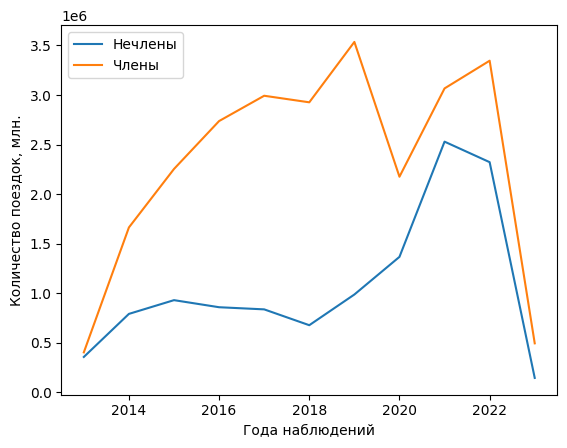

In [22]:
plt.plot(range(2013, 2024), casuals)
plt.plot(range(2013, 2024), members)
plt.xlabel('Года наблюдений')
plt.ylabel('Количество поездок, млн.')
plt.legend(['Нечлены', 'Члены'])
plt.title('Динамическое изменение количества членов и нечленов')
plt.show()

Как мы можем видеть, количество членов всегда превышало количество нечленов, однако в период самоизоляции разрыв уменьшался. Это может быть связано с тем, что люди стали пользоваться велопрокатом менее регулярно, из-за чего потребность уменьшилась.

Гипотезу можно считать подтвержденной

Посмотрим на распределение количества поездок в зависимости от возраста. Наша гипотеза заключается в том, что молодежь будет пользоваться чаще сервисом велопроката, т.к. это современная тенденция

In [23]:
age_hist = None
for year in range(2013, 2020):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    if year == 2013:
        age_hist = df[['id', 'age']].dropna()
        age_hist2 = age_hist[age_hist['age'] <= 100]
        age_hist = age_hist2.groupby(by=['age']).count()
    else:
        age = df[['id', 'age']].dropna()
        age2 = age[age['age'] <= 100]
        age = age2.groupby(by=['age']).count()
        age_hist = pd.concat([age_hist, age]).reset_index().groupby(by='age').sum()

In [24]:
res = age_hist.reset_index()
res = res[res['age'] < 100]

Text(0, 0.5, 'Количество поездок')

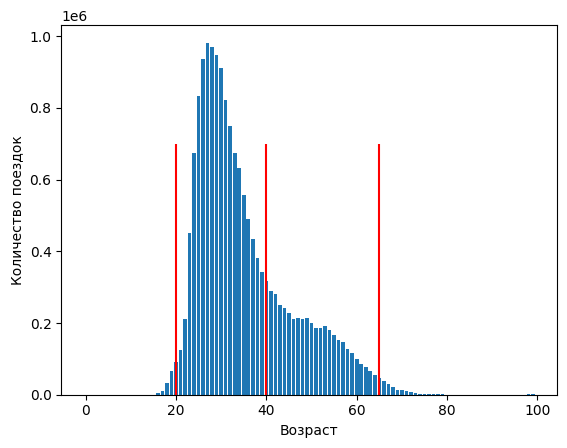

In [25]:
plt.bar(res['age'], res['id'])
plt.vlines(20, 0, 700000, color='r')
plt.vlines(40, 0, 700000, color='r')
plt.vlines(65, 0, 700000, color='r')
plt.xlabel('Возраст')
plt.ylabel('Количество поездок')
plt.title('Сегменты по возрастам')

Как мы видим, мы можем условно поделить клиентов велопроката на 4 сегмента:
1. До 20 лет;
2. От 20 до 40 лет;
3. От 40 до 65 лет;
4. От 65 лет.

При этом мы можем дополнительно классифицировать их следующим образом:
1. Пользуются очень часто - от 20 до 40 лет;
2. Пользуются средне - от 40 до 65 лет;
3. Практически не пользуются - до 20 лет и от 65 лет.

Это дает нам понимание, что основная аудитория велопроката - молодежь, потом идут люди средних лет.

Таким образом мы подтвердили гипотезу, а также получили дополнительную информацию о других сегментах

Продолжим исследовать сегменты, на этот раз проверим, как возраст влияет на членство. Наша гипотеза заключается в том, что членство будут выбирать чаще нечленства, т.к. это все еще выгодно для любого человека

In [26]:
types = {"<20": [0, 0], "20-39": [0, 0], "40-64": [0, 0], ">=65": [0, 0]}
for year in range(2013, 2020):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')[['age', 'member_casual']]
    types['<20'][0] += len(df[(df['age'] < 20) & (df['member_casual'] == 'Customer')])
    types['<20'][1] += len(df[(df['age'] < 20) & (df['member_casual'] == 'Subscriber')])
    types['20-39'][0] += len(df[(df['age'] >= 20) & (df['age'] < 40) & (df['member_casual'] == 'Customer')])
    types['20-39'][1] += len(df[(df['age'] >= 20) & (df['age'] < 40) & (df['member_casual'] == 'Subscriber')])
    types['40-64'][0] += len(df[(df['age'] >= 40) & (df['age'] < 65) & (df['member_casual'] == 'Customer')])
    types['40-64'][1] += len(df[(df['age'] >= 40) & (df['age'] < 65) & (df['member_casual'] == 'Subscriber')])
    types['>=65'][0] += len(df[(df['age'] >= 65) & (df['age'] <= 100) & (df['member_casual'] == 'Customer')])
    types['>=65'][1] += len(df[(df['age'] >= 65) & (df['age'] <= 100) & (df['member_casual'] == 'Subscriber')])

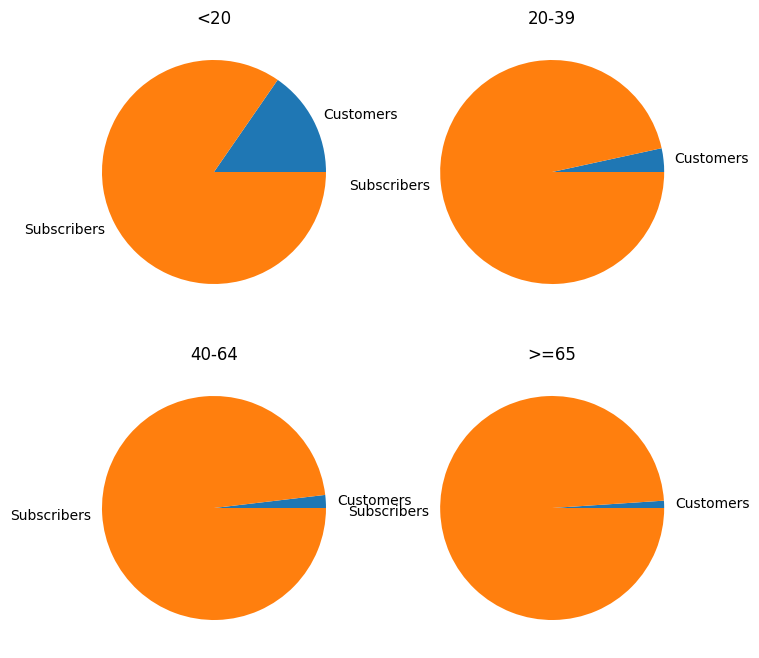

In [27]:
i = 1
plt.figure(figsize=(8, 8))
plt.suptitle('Соотношение членов к нечленам в сегментах')
for tp in list(types.keys()):
    plt.subplot(2, 2, i)
    plt.title(tp)
    plt.pie(types[tp], labels=['Customers', 'Subscribers'])
    i += 1

Вывод прост: гипотеза подтверждается, однако также необходимо заметить, что соотношение меняется в пользу членов с возрастом. Это может быть связано с достижением стабильности с возрастом

Продолжим развивать тему членства. На этот раз проверим, как члены и нечлены выбирают велосипед. Наша гипотеза заключается в том, что каждый тип велосипеда выбирают без зависимости от членства

In [28]:
types = None
res = None
for year in range(2020, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    types = df[['biketype', 'member_casual']]
    classes = pd.get_dummies(types['member_casual'])
    types = types.join(classes)
    types = types[['biketype', 'casual', 'member']].groupby(by='biketype').sum()
    if res is None:
        res = types
    else:
        res = pd.concat([res, types]).groupby(by='biketype').sum()
res

,casual,member
biketype,,
classic_bike,2218334,3991789
docked_bike,1642799,1820293
electric_bike,2501704,3268968


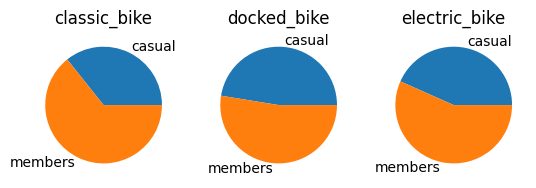

In [29]:
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(res.index.values[i])
    plt.pie(res.iloc[i].tolist(), labels=['casual', 'members'])
plt.suptitle('Соотношение членов к нечленам в зависимости от байка')

Как мы видим, диаграммы достаточно сильно отличаются, для docked_bike соотношение составляет почти 50/50. Можем говорить о том, что все же зависимость существует и гипотеза не подтверждается.

Закончим тему выбора клиентами велосипеда. Последнее, что мы проверим, - соотношение выбора различных типов (в среднем). Наша гипотеза заключается в том, что чаще всего будут использоваться классические и электрические байки

In [30]:
res = None
for year in range(2020, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    types = df[['biketype', 'id']].groupby(by='biketype').count()
    if res is None:
        res = types
    else:
        res = pd.concat([res, types]).groupby(by='biketype').sum()
res

,id
biketype,
classic_bike,6210123
docked_bike,3463092
electric_bike,5770672


([<matplotlib.patches.Wedge at 0x15f2c9180>,
 [Text(0.3329804101735338, 1.048391170527807, 'classic_bike'),
  Text(-1.095607807006059, -0.09820149299971943, 'docked_bike'),
  Text(0.42524506127276435, -1.0144785053726486, 'electric_bike')])

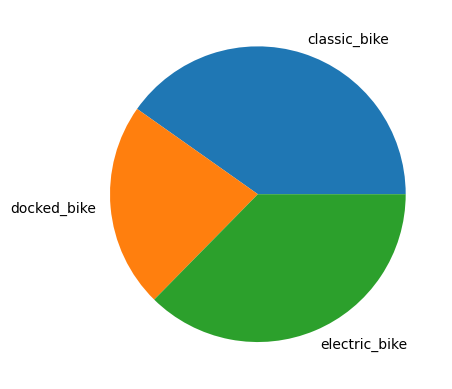

In [31]:
plt.pie(res['id'].tolist(), labels=res.reset_index()['biketype'].tolist())
plt.title('Среднее соотношение популярности байков')

Как мы видим, гипотеза подтверждена. Теперь мы знаем, что больше нравится клиентам велопроката

Также можно проанализировать прогулочные поездки. Таковыми мы будем считать поездки, начало и конец которых произошел на одной станции. Наша гипотеза будет заключаться в том, что они не пользуются популярностью (будем считать непопулярными показатели <10%)

In [32]:
res = []
percent_res = []
points = []
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    df = df[['startstation', 'endstation', 'startlat', 'startlng']].dropna()
    full = len(df)
    df = df[df['startstation'] == df['endstation']]
    points.extend((df['startlng'].astype(str) + ',' + df['startlat'].astype(str)).tolist())
    points = list(set(points))
    res.append(len(df))
    percent_res.append(len(df) / full)

In [33]:
print(sum(res) / 10.25)
print(sum(percent_res) / 10.25)

172793.46341463414
0.05615496163364775


Данные показатели являются средними. Как мы можем видеть, популярностью прогулочные поездки не пользуются. Но надо понимать, что данный показатель может изменяться, поэтому следует посмотреть на это в динамике 

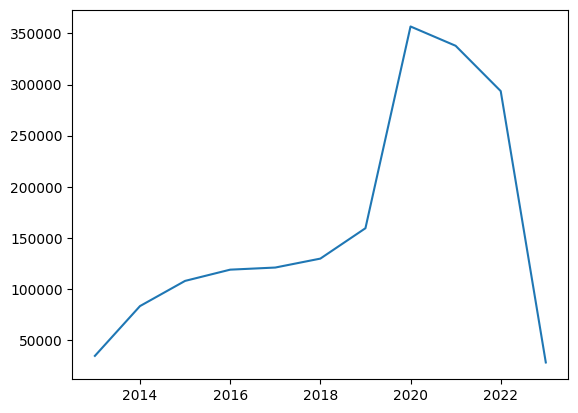

In [34]:
plt.plot(range(2013, 2024), res)
plt.xlabel('Годы')
plt.yalbel('Количество прогулочных поездок')
plt.title('Абсолютное количество прогулочных поездок')

По абсолютным величинам мы определяем рост количества прогулочных сессий в 2020, но такое может наблюдаться в случае, если увеличилось и количество всех поездок. Поэтому необходимо посмотреть на этот процессс в относительных величинах

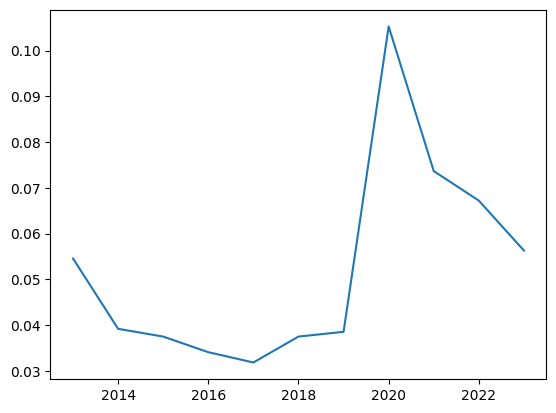

In [35]:
plt.plot(range(2013, 2024), percent_res)
plt.xlabel('Годы')
plt.ylabel('Доли прогулочных поездок')
plt.title('Прогулочные поездки в долях')

Теперь мы можем видеть, что в 2020 году из-за пандемии популярность прогулочных сессий сильно возросла и в относительных величинах, превысив 10%. Возможно, люди использовали велосипеды для скорейшего удовлетворения своих нужд, при этом они стремились минимизировать свое нахождение на улицах города

Гипотеза не подтверждается, однако мы получили информацию и том, как люди себя могут вести в наиболее опасных для здоровья ситуациях, и велопрокат сможет вовремя адаптироваться (произошел прецедент, если кратко)

Теперь узнаем, где чаще всего происходили прогулочные сессии. Наша гипотеза заключается в том, что сильной зависимости не будет

In [36]:
import requests


API_SERVER = "http://static-maps.yandex.ru/1.x"


def set_request(points):
    params = {"ll": "-87.623766,41.875732",
              "spn": "0.15,0.15",
              "l": 'map'}
    params['pt'] = '~'.join(points)
    image = requests.get(API_SERVER, params)
    with open('data/map.png', "wb") as file:
        file.write(image.content)

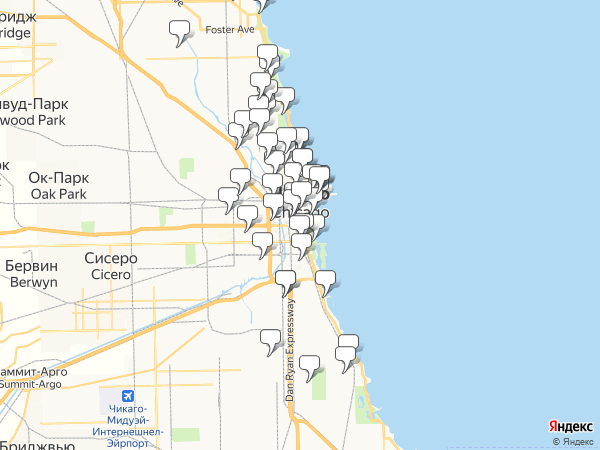

In [37]:
set_request(points[100:150])
from IPython.display import Image
Image(filename='data/map.png')

Как мы видим по карте, большинство прогулочных поездок совершались в центре города, но там и станций больше. Так что гипотезу можно считать подтвержденной

Теперь же можно рассчитать, сколько в среднем составляют доходы с нечленов

In [38]:
res = None


def get_price(df):
    df['output'] = (1 + df['output'] * 0.42) if df['biketype'] == 'docked_bike' or df['biketype'] == 'electric_bike' else (1 + df['output'] * 0.17)
    return df


for year in range(2020, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    df = df[['member_casual', 'biketype', 'starttime', 'endtime']].dropna()
    df = df[df['member_casual'] == 'casual']
    df['starttime'] = df['starttime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
    df['endtime'] = df['endtime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
    df['output'] = df['endtime'] - df['starttime']
    df = df[['biketype', 'output']].groupby(by='biketype').sum().reset_index()
    df['output'] = df['output'].apply(lambda x: x.total_seconds() / 60)
    df = df.apply(get_price, axis=1)
    if res is None:
        res = df
    else:
        res = pd.concat([res, df]).groupby('biketype').sum().reset_index()
print(res['output'].sum() / 3.25)

22780302.223435897


Теперь посмотрим на целевую аудиторию, основываясь на возрасте (не зря же делили на сегменты)

In [ ]:
conf = SparkConf().setAppName('test').setMaster('local')
sc = SparkContext(conf=conf)

Проверим, как меняется количество членов и нечленов в различные возрастные периоды. Наша гипотеза заключается в том, что возраст слабо влияет на использование подписки

In [39]:
df = pd.read_table(f'data/src/{2013}/part-00000', index_col=False, header=None,
              names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation',
                     'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age',
                     'bikeid'], sep=',')

for i in range(2014, 2020):
    df2 = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
              names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation',
                     'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age',
                     'bikeid'], sep=',')
    df = pd.concat([df, df2])

In [42]:
age_payment = df[['age', 'member_casual']]
age_payment = age_payment.dropna()
age_payment = age_payment[age_payment['age'] <= 100]
age_payment

,age,member_casual
2,25.0,Subscriber
3,38.0,Subscriber
6,37.0,Subscriber
7,52.0,Subscriber
8,41.0,Subscriber
...,...,...
4522053,62.0,Subscriber
4522054,32.0,Subscriber
4522055,43.0,Customer
4522056,32.0,Subscriber


In [43]:
age_payment_cust = age_payment[age_payment['member_casual'] == 'Customer']
age_payment_sub = age_payment[age_payment['member_casual'] == 'Subscriber']

age_bins_sub = pd.cut(age_payment_sub['age'],
                    [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, age_payment_sub['age'].max()],
                    include_lowest=True)
age_bins_cust = pd.cut(age_payment_cust['age'],
                    [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, age_payment_cust['age'].max()],
                    include_lowest=True)
age_payment_sub['age_bins'] = age_bins_sub
age_payment_cust['age_bins'] = age_bins_cust

/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/2241500041.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_payment_sub['age_bins'] = age_bins_sub
/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/2241500041.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_payment_cust['age_bins'] = age_bins_cust


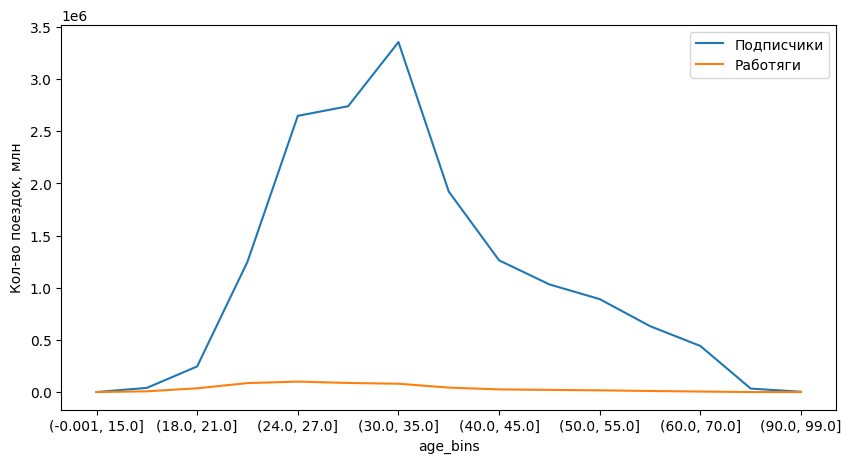

In [44]:
age_payment_sub = age_payment_sub.groupby('age_bins')['member_casual'].count()
age_payment_cust = age_payment_cust.groupby('age_bins')['member_casual'].count()

plt.figure(figsize=(10, 5))
plt.xlabel('Возрастные отрезки, года')
plt.ylabel('Кол-во поездок, млн')
plt.title('Зависимость возраста на членство')
age_payment_sub.plot()
age_payment_cust.plot()
plt.legend(['Члены', 'Нечлены'])
plt.show()

Как мы можем видеть, наша гипотеза вполне подтверждается, количество людей, использующих единоразовые аренды практически не изменяется с возрастом, чего не скажешь о подписке, однако на общий вывод это не влияет

Посмотрим на зависимость продолжительности поездки и возраста. Наша гипотеза заключается в том, что больше всего будут кататься молодежь и люди пожилого/предпожилого возраста, т.к. первые пока еще просто играются, а вторые слишком медлительны. Люди средних лет заняты работой, поэтому используют данное средство по прямому назначению

In [56]:
age_time = df[['age', 'starttime', 'endtime']]
age_time['starttime'] = pd.to_datetime(age_time['starttime'])
age_time['endtime'] = pd.to_datetime(age_time['endtime'])
age_time['duration'] = round((age_time['endtime'] - age_time['starttime']).dt.seconds / 60)
age_time2 = age_time[['age', 'duration']]

age_bins = pd.cut(age_time2['age'],
                  [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, 100],
                  include_lowest=True)
age_time2['age_bins'] = age_bins
age_time2 = age_time2[age_time2['age'] <= 100]
age_time2 = age_time2.dropna().groupby('age_bins')['duration'].mean()
age_time2

/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/970473847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_time['starttime'] = pd.to_datetime(age_time['starttime'])
/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/970473847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_time['endtime'] = pd.to_datetime(age_time['endtime'])
/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/970473847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a

age_bins
(-0.001, 15.0]    18.698238
(15.0, 18.0]      16.966163
(18.0, 21.0]      14.832468
(21.0, 24.0]      13.538866
(24.0, 27.0]      13.027989
(27.0, 30.0]      13.072335
(30.0, 35.0]      12.874786
(35.0, 40.0]      12.909448
(40.0, 45.0]      12.858801
(45.0, 50.0]      12.548296
(50.0, 55.0]      12.694010
(55.0, 60.0]      13.135800
(60.0, 70.0]      12.914184
(70.0, 90.0]      14.692811
(90.0, 100.0]     14.585977
Name: duration, dtype: float64

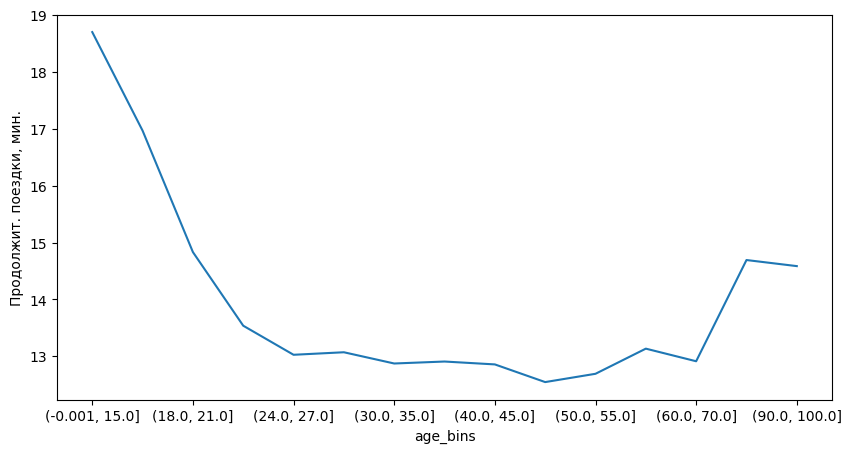

In [57]:
plt.figure(figsize=(10, 5))
plt.xlabel('Возрастные отрезки, года')
plt.ylabel('Продолжит. поездки, мин.')
plt.title('Изменение продолжительности поездки в зависимости от возраста')
age_time2.plot()
plt.show()

Как мы видим, гипотеза вполне подтверждается, график действительно уменьшается в начале и немного растет в конце

Теперь посмотрим на зависимость времени поездки от возраста (в среднем). Гипотеза будет заключаться в том, что такой зависимости не наблюдается

In [58]:
age_bins = pd.cut(age_time['age'],
                  [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, 100],
                  include_lowest=True)
age_time['starttime'] = age_time['starttime'].dt.hour + age_time['starttime'].dt.minute / 60
age_time['age_bins'] = age_bins
age_time = age_time[age_time['age'] <= 100]
age_time = age_time[['age_bins', 'starttime']]
age_time = age_time.dropna().groupby('age_bins')['starttime'].mean()

/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/3050042826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_time['starttime'] = age_time['starttime'].dt.hour + age_time['starttime'].dt.minute / 60
/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/3050042826.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_time['age_bins'] = age_bins


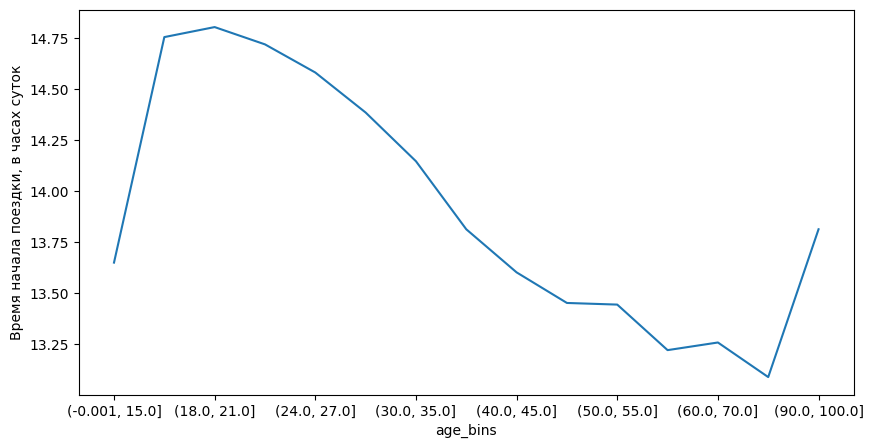

In [59]:
plt.figure(figsize=(10, 5))
plt.ylabel('Время начала поездки, в часах суток')
age_time.plot()
plt.title('Время начала поездки и возраст')
plt.show()

По графику мы видим, что некоторая разница все же наблюдается, так что гипотеза опровергнута

Теперь посмотрим на зависимость пола от возраста. Наша гипотеза заключается в том, что молодые парни будут чуть чаще "играться" с велопрокатом

In [60]:
age_gender = df[['age', 'gender']]
age_gender = age_gender[age_gender['age'] <= 100]
age_gender['age_bins'] = pd.cut(age_gender['age'],
                  [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, 100],
                  include_lowest=True)
age_gender = age_gender.dropna()
age_male = age_gender[age_gender['gender'] == 'Male'].groupby(['age_bins'])['gender'].count()
age_female = age_gender[age_gender['gender'] == 'Female'].groupby(['age_bins'])['gender'].count()
age_gender

,age,gender,age_bins
2,25.0,Male,"(24.0, 27.0]"
3,38.0,Male,"(35.0, 40.0]"
6,37.0,Male,"(35.0, 40.0]"
7,52.0,Male,"(50.0, 55.0]"
8,41.0,Female,"(40.0, 45.0]"
...,...,...,...
4522053,62.0,Male,"(60.0, 70.0]"
4522054,32.0,Male,"(30.0, 35.0]"
4522055,43.0,Female,"(40.0, 45.0]"
4522056,32.0,Male,"(30.0, 35.0]"


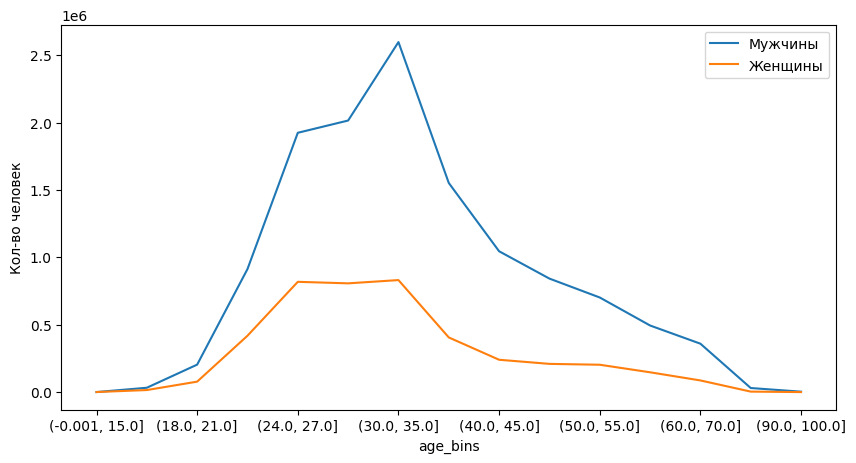

In [61]:
plt.figure(figsize=(10, 5))
plt.ylabel('Кол-во человек')
age_male.plot()
age_female.plot()
plt.legend(['Мужчины', 'Женщины'])
plt.title('Зависимость количества мужчин и женщин от возраста')
plt.show()

Молодежь оправдала ожидания, гипотеза доказана

In [62]:
stations = df[['startstation', 'id']]
stations['startstation'] = stations['startstation'].dropna()
stations = stations.groupby('startstation').count().sort_values(by='id', ascending=False)
FIRST_N = 10
stations = stations.head(FIRST_N).axes[0].values.tolist()
print(stations)
startstation_age = df[['startstation', 'age']]
startstation_age = startstation_age.dropna().groupby('startstation').mean()
print(startstation_age)

/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/904792197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['startstation'] = stations['startstation'].dropna()


['Streeter Dr & Grand Ave', 'Lake Shore Dr & Monroe St', 'Clinton St & Washington Blvd', 'Canal St & Adams St', 'Clinton St & Madison St', 'Theater on the Lake', 'Lake Shore Dr & North Blvd', 'Michigan Ave & Oak St', 'Millennium Park', 'Canal St & Madison St']
                                    age
startstation                           
2112 W Peterson Ave           40.827603
63rd St Beach                 38.586425
900 W Harrison                36.527417
900 W Harrison St             33.882468
Aberdeen St & Jackson Blvd    34.891432
...                                 ...
Wood St & Taylor St           35.172145
Woodlawn Ave & 55th St        33.073879
Woodlawn Ave & 75th St        38.031915
Woodlawn Ave & Lake Park Ave  41.895544
Yates Blvd & 75th St          35.781250

[745 rows x 1 columns]


Как же возраст связан с самыми популярными станциями?

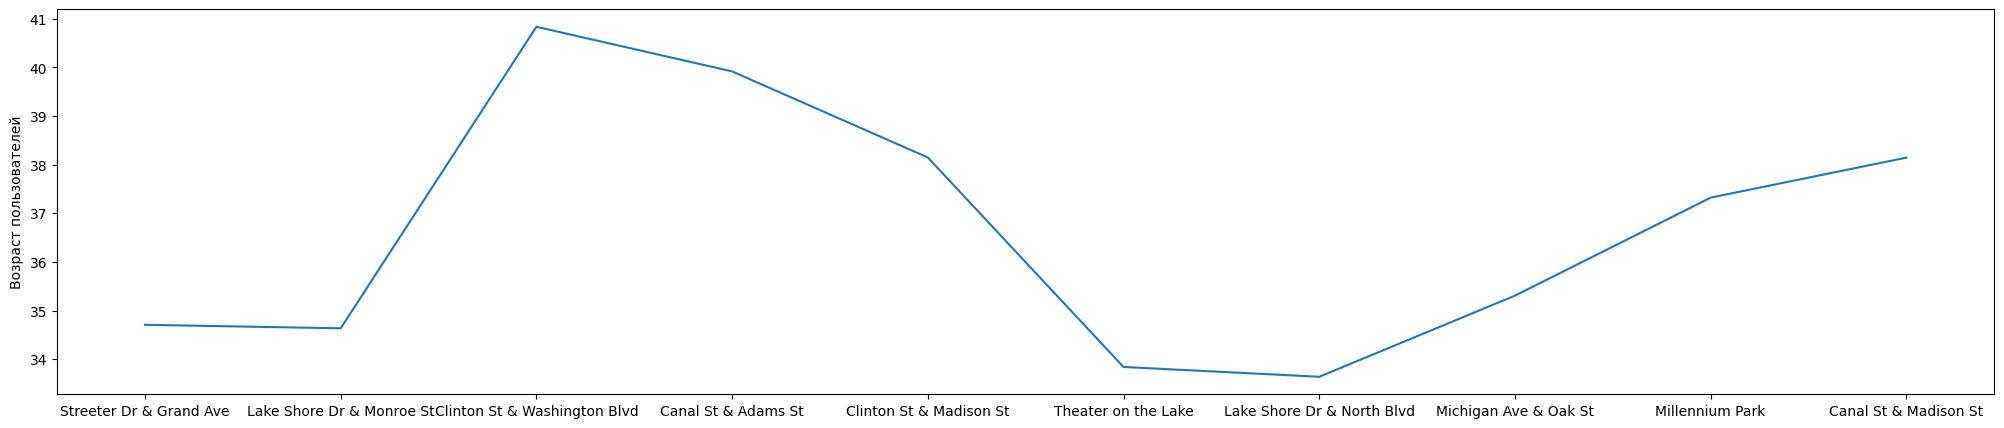

In [63]:
data = {'station': [], 'age': []}
for i in range(FIRST_N):
    # print(startstation_age.axes[0].values)
    data['age'].append(startstation_age.loc[stations[i]][0])
    data['station'].append(stations[i])
plt.figure(figsize=(25, 5))
plt.ylabel('Возраст пользователей')
df2 = pd.DataFrame(data).set_index('station')
plt.plot(df2)
plt.title('Популярные станции и возраст')
plt.show()

А никак не связан

Теперь можно еще раз раскрыть тему половой принадлежности

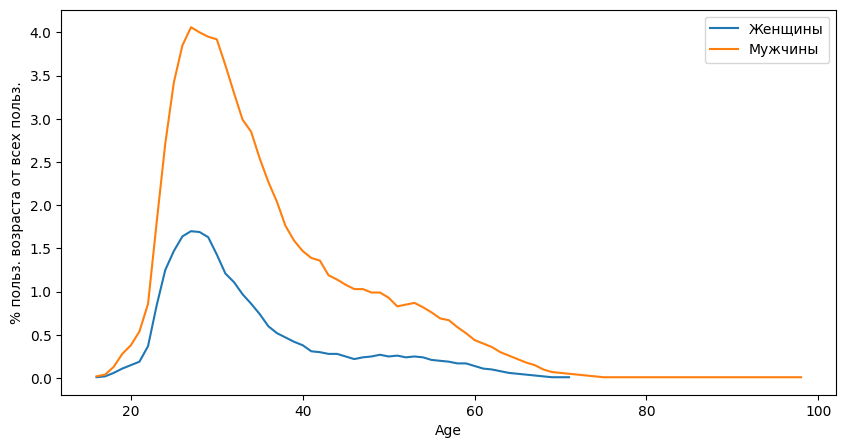

In [64]:
def parse(line):
    info = line.split(',')
    # float(info[-2]) - возраст
    # float(info[-3]) - пол
    return [((info[-3], info[-2]), 1)]


df0 = sc.textFile(f'data/src/{2013}/part-00000')
for i in range(2014, 2020):
    df0 = df0.union(sc.textFile(f'data/src/{i}/part-00000'))

df0 = df0.flatMap(parse).filter(lambda tup: tup[0][0] != '' and tup[0][1] != '').\
    map(lambda tup: ((tup[0][0], float(tup[0][1])), 1)).reduceByKey(lambda v1, v2: v1 + v2)\
    .collect()
summ = 0
for i in df0:
    summ += i[1]

data = {'Gender': [], 'Age': [], 'Num': []}
for i in df0:
    perc = round(i[1] / summ * 100, 2)
    if perc > 0:
        data['Gender'].append(i[0][0])
        data['Age'].append(i[0][1])
        data['Num'].append(perc)

        
plt.figure(figsize=(10, 5))
plt.ylabel('% польз. возраста от всех польз.')
df3 = pd.DataFrame(data)
df3_male = df3[df3['Gender'] == 'Male']
df3_female = df3[df3['Gender'] == 'Female']
df3_male = df3_male.groupby('Age')['Num'].sum()
df3_female = df3_female.groupby('Age')['Num'].sum()
df3_female.plot()
df3_male.plot()
plt.legend(['Женщины', 'Мужчины'])
plt.title('Доли мужчин и женщин в зависимости от возраста')
plt.show()

В процентом соотношении результаты получились схожи с предыдущими результатами, но график стал еще более наглядным

Теперь посмотрим в динамике, как менялась средняя продолжительность поездки. Наша гипотеза будет заключаться в том, что она не изменялась со временем

                   endtime           starttime   age      age_bins  duration
0      2013-07-29 19:21:00 2013-07-29 19:03:00   NaN           NaN      18.0
1      2013-08-04 00:46:00 2013-08-04 00:22:00   NaN           NaN      24.0
2      2013-07-18 00:09:00 2013-07-17 23:45:00  25.0  (24.0, 27.0]      24.0
3      2013-09-23 20:24:00 2013-09-23 19:58:00  38.0  (35.0, 40.0]      26.0
4      2013-07-17 10:18:00 2013-07-17 09:53:00   NaN           NaN      25.0
...                    ...                 ...   ...           ...       ...
759783 2013-12-28 15:17:00 2013-12-28 15:13:00  46.0  (45.0, 50.0]       4.0
759784 2013-12-28 21:27:00 2013-12-28 21:20:00  36.0  (35.0, 40.0]       7.0
759785 2013-12-28 21:36:00 2013-12-28 21:34:00  21.0  (18.0, 21.0]       2.0
759786 2013-08-30 21:15:00 2013-08-30 20:59:00  54.0  (50.0, 55.0]      16.0
759787 2013-08-30 21:30:00 2013-08-30 21:16:00  54.0  (50.0, 55.0]      14.0

[759788 rows x 5 columns]
                    endtime           starttime  

/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/1351067448.py:22: RuntimeWarning: invalid value encountered in scalar divide
  srednee_dur.append(df_durs.sum() / len(df_durs))


                    endtime           starttime  age age_bins  duration
0       2021-09-28 16:09:54 2021-09-28 16:07:10  NaN      NaN       3.0
1       2021-09-28 14:40:05 2021-09-28 14:24:51  NaN      NaN      15.0
2       2021-09-28 00:23:57 2021-09-28 00:20:16  NaN      NaN       4.0
3       2021-09-28 15:00:06 2021-09-28 14:51:17  NaN      NaN       9.0
4       2021-09-28 10:03:44 2021-09-28 09:53:12  NaN      NaN      11.0
...                     ...                 ...  ...      ...       ...
5595058 2021-05-20 16:35:39 2021-05-20 16:32:14  NaN      NaN       3.0
5595059 2021-05-29 17:22:37 2021-05-29 16:40:37  NaN      NaN      42.0
5595060 2021-05-31 14:31:38 2021-05-31 14:24:54  NaN      NaN       7.0
5595061 2021-05-25 16:07:37 2021-05-25 16:01:33  NaN      NaN       6.0
5595062 2021-05-12 12:30:27 2021-05-12 12:22:14  NaN      NaN       8.0

[5595063 rows x 5 columns]


/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/1351067448.py:22: RuntimeWarning: invalid value encountered in scalar divide
  srednee_dur.append(df_durs.sum() / len(df_durs))


                    endtime           starttime  age age_bins  duration
0       2022-08-07 21:41:46 2022-08-07 21:34:15  NaN      NaN       8.0
1       2022-08-08 14:53:23 2022-08-08 14:39:21  NaN      NaN      14.0
2       2022-08-08 15:40:34 2022-08-08 15:29:50  NaN      NaN      11.0
3       2022-08-08 02:58:53 2022-08-08 02:43:50  NaN      NaN      15.0
4       2022-08-07 20:29:58 2022-08-07 20:24:06  NaN      NaN       6.0
...                     ...                 ...  ...      ...       ...
5667712 2022-09-05 18:19:07 2022-09-05 17:59:21  NaN      NaN      20.0
5667713 2022-09-30 17:34:40 2022-09-30 17:20:54  NaN      NaN      14.0
5667714 2022-09-04 11:50:55 2022-09-04 11:39:37  NaN      NaN      11.0
5667715 2022-09-28 13:52:59 2022-09-28 13:42:45  NaN      NaN      10.0
5667716 2022-09-01 20:18:01 2022-09-01 20:07:04  NaN      NaN      11.0

[5667717 rows x 5 columns]


/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/1351067448.py:22: RuntimeWarning: invalid value encountered in scalar divide
  srednee_dur.append(df_durs.sum() / len(df_durs))


                   endtime           starttime  age age_bins  duration
0      2023-03-16 08:22:52 2023-03-16 08:20:34  NaN      NaN       2.0
1      2023-03-04 14:15:31 2023-03-04 14:07:06  NaN      NaN       8.0
2      2023-03-31 12:38:47 2023-03-31 12:28:09  NaN      NaN      11.0
3      2023-03-22 14:24:51 2023-03-22 14:09:08  NaN      NaN      16.0
4      2023-03-09 07:26:00 2023-03-09 07:15:00  NaN      NaN      11.0
...                    ...                 ...  ...      ...       ...
639419 2023-01-11 17:57:31 2023-01-11 17:46:23  NaN      NaN      11.0
639420 2023-01-30 15:33:26 2023-01-30 15:08:10  NaN      NaN      25.0
639421 2023-01-06 19:50:01 2023-01-06 19:34:50  NaN      NaN      15.0
639422 2023-01-13 19:14:44 2023-01-13 18:59:24  NaN      NaN      15.0
639423 2023-01-02 13:59:29 2023-01-02 13:48:29  NaN      NaN      11.0

[639424 rows x 5 columns]


/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/1351067448.py:22: RuntimeWarning: invalid value encountered in scalar divide
  srednee_dur.append(df_durs.sum() / len(df_durs))


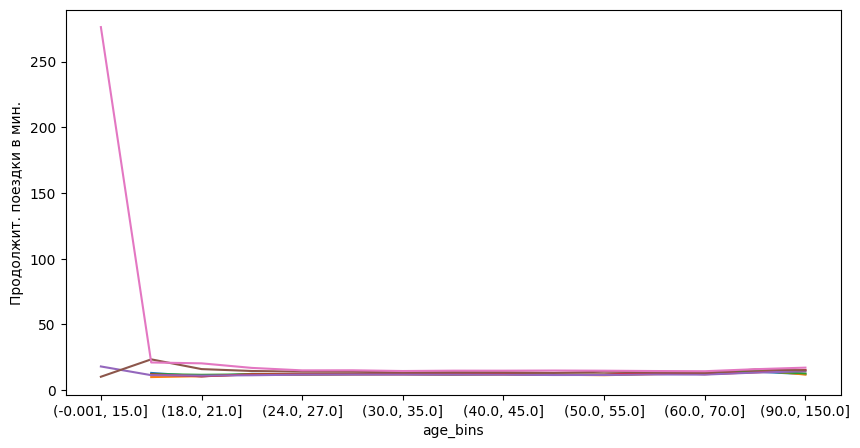

In [65]:
srednee_dur = []
plt.figure(figsize=(10, 5))
plt.ylabel('Продолжит. поездки в мин.')
for i in range(2013, 2024):
    df = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
                       names=['id', 'biketype', 'starttime', 'endtime', 'startstation',
                              'endstation',
                              'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender',
                              'age',
                              'bikeid'], sep=',')
    df = df[['endtime', 'starttime', 'age']]
    df['age_bins'] = pd.cut(df['age'],
                  [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, 150],
                  include_lowest=True)
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['endtime'] = pd.to_datetime(df['endtime'])
    df['duration'] = round((df['endtime'] - df['starttime']).dt.seconds / 60)
    print(df)
    df = df.dropna().groupby('age_bins')['duration'].mean()
    df_durs = df.values
    df_durs = df_durs[~np.isnan(df_durs)]
    srednee_dur.append(df_durs.sum() / len(df_durs))
    df.plot()
plt.show()

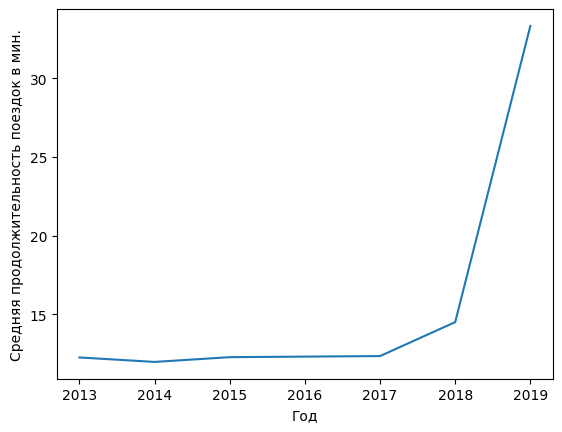

In [66]:
plt.xlabel('Год')
plt.ylabel('Средняя продолжительность поездок в мин.')
plt.plot(range(2013, 2024), srednee_dur)
plt.title('Динамика продолжительности поездки')
plt.show()

Сильного роста не наблюдалось вплоть до 2019 года, гипотеза опровергнута, но требуется узнать, что такое могло произойти

In [67]:
from pprint import pprint
from datetime import datetime


def parse2(line):
    info = line.split(',')
    dur = (datetime.fromisoformat(info[3]) - datetime.fromisoformat(info[2])).seconds / 60
    return [(dur, (int(info[0]), info[2], info[3], info[-3], info[-2], dur))]


df0 = sc.textFile(f'data/src/2019/part-00000')
df0 = df0.flatMap(parse2).top(20)
pprint(df0)

[(1439.9333333333334,
  (24699285,
   '2019-08-31T13:10:42',
   '2019-09-02T13:10:38',
   '',
   '',
   1439.9333333333334)),
 (1439.75,
  (22689896,
   '2019-05-16T17:08:27',
   '2019-05-17T17:08:12',
   'Female',
   '56',
   1439.75)),
 (1439.6833333333334,
  (25471668,
   '2019-10-18T14:59:48',
   '2019-11-05T14:59:29',
   '',
   '',
   1439.6833333333334)),
 (1439.6833333333334,
  (25471668,
   '2019-10-18T14:59:48',
   '2019-11-05T14:59:29',
   '',
   '',
   1439.6833333333334)),
 (1439.15,
  (24134798, '2019-08-02T22:25:13', '2019-08-03T22:24:22', '', '', 1439.15)),
 (1438.5666666666666,
  (25384091,
   '2019-10-11T12:47:29',
   '2019-10-15T12:46:03',
   '',
   '',
   1438.5666666666666)),
 (1438.5666666666666,
  (25384091,
   '2019-10-11T12:47:29',
   '2019-10-15T12:46:03',
   '',
   '',
   1438.5666666666666)),
 (1438.3333333333333,
  (23276862,
   '2019-06-21T09:49:00',
   '2019-07-03T09:47:20',
   '',
   '',
   1438.3333333333333)),
 (1438.2833333333333,
  (23276864,
   '2019

В 2019 году, похоже, был какой-то марафон, и все взяли напрокат велосипеды!

И да, в 2019 году действительно в Чикаго был заезд на байках... Но не "классический"

Теперь посмотрим в динамике, как менялся средний возраст клиентов. Наша гипотеза заключается в том, что он плавно уменьшался, т.к. молодежь любит тренды

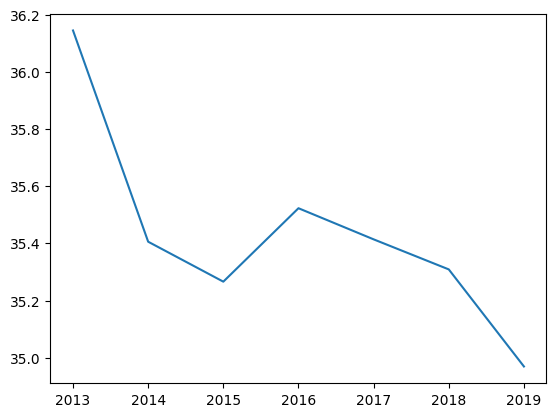

In [68]:
sredniy_age = []
for i in range(2013, 2024):
    df = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
                       names=['id', 'biketype', 'starttime', 'endtime', 'startstation',
                              'endstation',
                              'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender',
                              'age',
                              'bikeid'], sep=',')
    df = df[['age']]
    sredniy_age.append(df['age'].mean())
plt.plot(range(2013, 2024), sredniy_age)
plt.xlabel('Годы')
plt.ylabel('Возраст')
plt.title('Динамика возраста по годам')
plt.xlabel('Годы')
plt.ylabel('Средний возраст')
plt.show()

Гипотеза доказана, действительно все идет к тому, что возраст медленно но снижается, хотя бывают и скачки

Как же менялся возраст пользователей в динамике? Гипотеза: остался практически идентичным

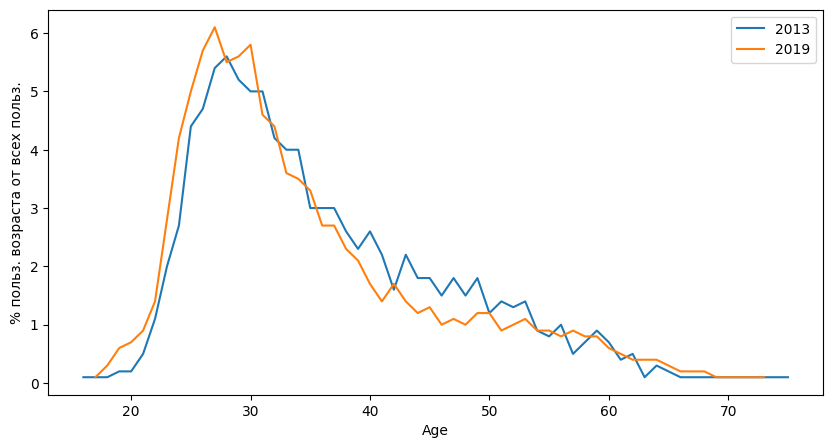

In [69]:
plt.figure(figsize=(10, 5))
plt.ylabel('% польз. возраста от всех польз.')
for i in [2013, 2019]:
    df0 = sc.textFile(f'data/src/{i}/part-00000')
    df0 = df0.flatMap(parse).filter(lambda tup: tup[0][0] != '' and tup[0][1] != '').\
        map(lambda tup: (float(tup[0][1]), 1)).reduceByKey(lambda v1, v2: v1 + v2)\
        .collect()
    summ = 0
    for i in df0:
        summ += i[1]
    data = {'Age': [], 'Num': []}
    for i in df0:
        perc = round(i[1] / summ * 100, 1)
        if perc > 0:
            data['Age'].append(i[0])
            data['Num'].append(perc)
    df3 = pd.DataFrame(data).groupby('Age')['Num'].sum()
    df3.plot()
plt.legend(['2013', '2019'])
plt.title('Процент возраста')
plt.show()

В 2013 и 2019 годах графики близки друг к другу, мы можем сказать, что популярность среди молодежи выросла, а среди людей среднего возраста упала

### Велосипеды

Для расчета экономики нам важно определить, как часто необходимо ремонтировать те или иные типы велосипедов, сколько требуется их покупать в год для обеспечения клиентов средствами передвижения

In [ ]:
conf = SparkConf().setAppName('test').setMaster('local')
sc = SparkContext(conf=conf)

Определяем функции, которые необходимы для вычисления 

In [70]:
def get_shortest_distance(lat1, lon1, lat2, lon2):
    return acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon2 - lon1)) * 6371


def parse_table1(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    return (bikeid, 1)


def parse_table2(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    V_AVG = 12/3.6/1000
    startt = datetime.datetime.strptime(startt, '%Y-%m-%dT%H:%M:%S')
    endt = datetime.datetime.strptime(endt, '%Y-%m-%dT%H:%M:%S')
    duration = endt - startt
    return (bikeid, V_AVG*duration.total_seconds())


def parse_table3(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    return (bikeid, startt[0:7])

Определяем основные параметры для вычислений:
1. При каком пробеге необходим ремонт;
2. Стоимость ремонта различных типов байков (объединим docked и electric);
3. Стоимость покупки различных типов байков

In [71]:
REPAIR_LIM = 10000
REPAIR_PRICE = 60
eREPAIR_PRICE = 80
BIKE_PRICE = 1500
eBIKE_PRICE = 2000

Определяем, сколько в различные года существовало уникальных байков

In [72]:
unique_by_year = []
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"data/src/{y}").map(parse_table1) \
                                          .reduceByKey(lambda a, b: a + b) \
                                          .map(lambda x: (None, 1)) \
                                          .reduceByKey(lambda a, b: a + b) \
                                          .collect()
    unique_by_year.append((y, df[0][1]))
print("Уникальные велосипеды по годам:", unique_by_year)

Уникальные велосипеды по годам: [(2013, 2887), (2014, 2968), (2015, 4724), (2016, 5748), (2017, 6243), (2018, 6133), (2019, 6017)]


Работаем с ремонтами

In [75]:
import datetime
cum_repairs = []
run = []
big = sc.parallelize([])
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"data/src/{y}").map(parse_table2) \
                                          .reduceByKey(lambda a, b: a + b)
    big = big.union(df)
    analyse_rep = big.map(lambda x: (None, floor(x[1] / REPAIR_LIM))) \
                 .reduceByKey(lambda a, b: a + b) \
                 .collect()
    cum_repairs.append((y, analyse_rep[0][1]))
    analyse_run = df.map(lambda x: (None, x[1])) \
                    .reduceByKey(lambda a, b: a + b) \
                    .collect()
    run.append((y, analyse_run[0][1]))
print("Накопительное количество ремонтов по годам: ", cum_repairs)
print("Пробег по годам: ", run)

Накопительное количество ремонтов по годам:  [(2013, 0), (2014, 0), (2015, 0), (2016, 0), (2017, 0), (2018, 179), (2019, 412)]
Пробег по годам:  [(2013, 3138681.0), (2014, 8386190.200000001), (2015, 10866616.599999998), (2016, 11902134.776666671), (2017, 12197054.793333333), (2018, 16972177.416666668), (2019, 21250863.87666667)]


In [76]:
cum = 0
repairs = []
for y, s in cum_repairs:
    repairs.append((y, s - cum))
    cum = s
print("Количество ремонтов по годам: ", repairs)
repair_prices = [(y, x * 0.6 * eREPAIR_PRICE + x * 0.4 * REPAIR_PRICE) for y, x in repairs]
print("Затраты на ремонт по годам: ", repair_prices)
print("Средние затраты по годам: ", sum([x for y, x in repair_prices]) / len(list(filter(lambda x: x[1] != 0, repair_prices))))

Количество ремонтов по годам:  [(2013, 0), (2014, 0), (2015, 0), (2016, 0), (2017, 0), (2018, 179), (2019, 233)]
Затраты на ремонт по годам:  [(2013, 0.0), (2014, 0.0), (2015, 0.0), (2016, 0.0), (2017, 0.0), (2018, 12888.0), (2019, 16776.0)]
Средние затраты по годам:  14832.0


Расчитываем затраты на закупку велосипедов

In [77]:
big = sc.parallelize([])
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"data/src/{y}").map(parse_table3)
    big = big.union(df)
unique = big.reduceByKey(lambda a, b: a if a < b else b) \
            .map(lambda x: (x[1], 1)) \
            .reduceByKey(lambda a, b: a + b) \
            .collect()
unique_by_year2 = []
for y in range(2013, 2019 + 1):
    summa = 0
    for d, x in unique:
        if str(y) in d:
            summa += x
    unique_by_year2.append((y, summa))
print("Новые уникальные велосипеды по месяцам:", unique)
print("Новые уникальные велосипеды по годам:", unique_by_year2)
avg_bike = sum([x for y, x in unique_by_year2]) / len(unique_by_year2)
print("Среднее новых по годам: ", avg_bike)
print("Средние затраты на велосипеды: ", avg_bike * 0.6 * eBIKE_PRICE + avg_bike * 0.4 * BIKE_PRICE)

Новые уникальные велосипеды по месяцам: [('2016-12', 1), ('2015-06', 40), ('2016-08', 9), ('2015-08', 3), ('2016-10', 1), ('2015-03', 3), ('2015-05', 1200), ('2013-07', 389), ('2014-04', 3), ('2015-04', 517), ('2017-10', 1), ('2013-10', 345), ('2016-05', 205), ('2016-06', 694), ('2014-10', 3), ('2014-05', 28), ('2013-06', 598), ('2016-11', 2), ('2013-12', 66), ('2013-11', 12), ('2015-01', 1), ('2016-07', 155), ('2013-08', 755), ('2017-08', 223), ('2014-01', 3), ('2013-09', 722), ('2017-04', 1), ('2017-09', 1), ('2014-09', 2), ('2019-11', 139), ('2016-09', 8), ('2017-07', 326), ('2014-03', 65), ('2015-07', 4)]
Новые уникальные велосипеды по годам: [(2013, 2887), (2014, 104), (2015, 1768), (2016, 1075), (2017, 552), (2018, 0), (2019, 139)]
Среднее новых по годам:  932.1428571428571
Средние затраты на велосипеды:  1677857.1428571427


Визуализируем полученные данные в динамике

Text(0.5, 0, 'Год')

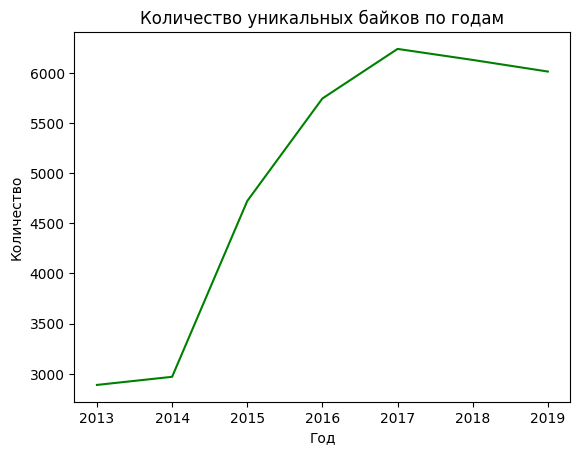

In [78]:
pdf = pd.DataFrame(unique_by_year)
plt.plot(pdf[0], pdf[1], c="green")
plt.title("Количество уникальных байков по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

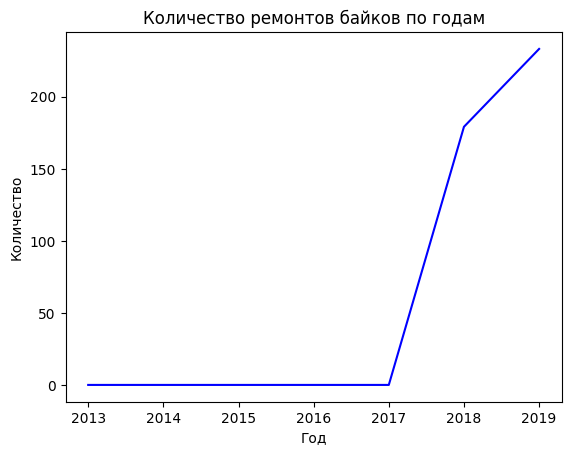

In [79]:
pdf = pd.DataFrame(repairs)
plt.plot(pdf[0], pdf[1], c="blue")
plt.title("Количество ремонтов байков по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

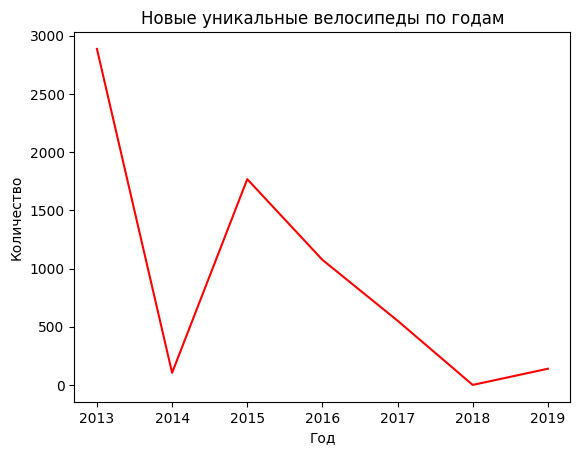

In [80]:
pdf = pd.DataFrame(unique_by_year2)
plt.plot(pdf[0], pdf[1], c="red")
plt.title("Новые уникальные велосипеды по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

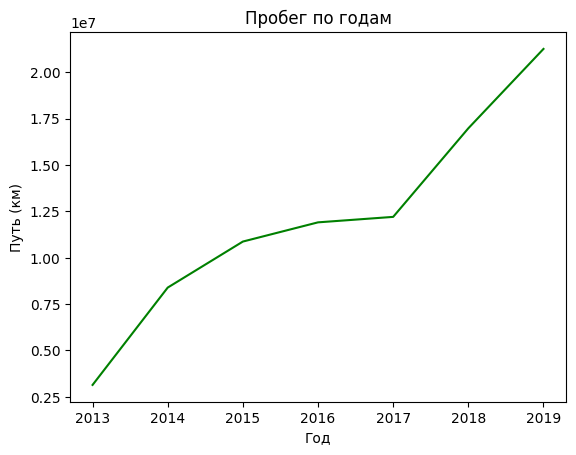

In [81]:
pdf = pd.DataFrame(run)
plt.plot(pdf[0], pdf[1], c="green")
plt.title("Пробег по годам")
plt.ylabel("Путь (км)")
plt.xlabel("Год")

Какие выводы можно сделать из графиков за 2013-2019 года?
1. Велосипедная сеть росла, лишь в 2019 году наблюдается незначительный спад количества уникальных байков
2. График ремонта байков будет цикличен. Divvy основан в 2013 году, в этом году введена большая часть велосипедов этой сети (вторая часть была введена в эксплуатацию после расширения сети в 2015 году). Значит, по истечении 2-х лет количество ремонтов байков достигнет пика, затем снова пойдет спад. В 2018 году идет наложение ремонта сразу двух "подгрупп" велосипедов (2013 + 2015) => Нужно вводить велосипеды в использование равномерно

В анализе целевой аудитории мы визуализировали среднее сотношение различных типов байков. На этот раз мы посмотрим на это в динамике.

In [82]:
ebikes = []
dbikes = []
bikes = []
for year in range(2020, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    ebikes.append(len(df[df['biketype'] == 'electric_bike']))
    dbikes.append(len(df[df['biketype'] == 'docked_bike']))
    bikes.append(len(df[df['biketype'] == 'classic_bike']))

Text(0, 0.5, 'Количество поездок')

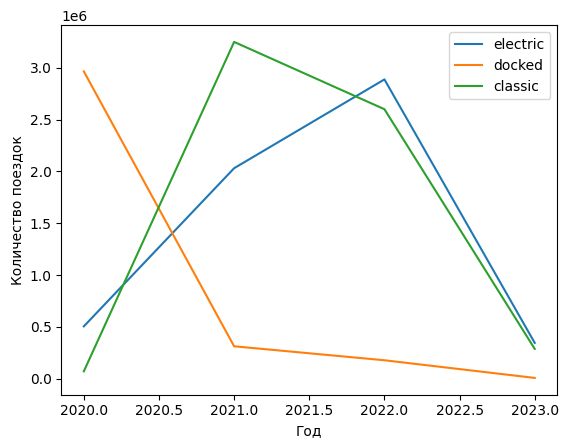

In [83]:
plt.plot(range(2020, 2024), ebikes)
plt.plot(range(2020, 2024), dbikes)
plt.plot(range(2020, 2024), bikes)
plt.legend(['electric', 'docked', 'classic'])
plt.xlabel('Год')
plt.ylabel('Количество поездок')
plt.title('Динамика популярности типов велосипедов')

Из графика мы можем наблюдать за ростом популярности электрических велосипедов в последние годы, однако классические от них отстали не так уж и сильно

### Станции

Теперь необходимо определить, какие станции, существующие в 2023 года (гарантированно), будут наиболее выгодны

Определим, зависит ли популярность типа байка от количества поездок на станции. Наша гипотеза заключается в том, что такой зависимости нет

In [84]:
df = pd.read_table(f'data/src/2023/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
stations = df[['id', 'startstation', 'biketype']].rename(columns={'startstation': 'station'}).groupby(by=['station']).agg({'id': 'count', 'biketype': pd.Series.mode}).reset_index()

In [85]:
stations.sort_values(by=['id'], ascending=False).rename(columns={"id":"count"})[:10]

,station,count,biketype
1009,University Ave & 57th St,5908,classic_bike
265,Ellis Ave & 60th St,5744,classic_bike
179,Clinton St & Washington Blvd,5250,electric_bike
407,Kingsbury St & Kinzie St,4932,classic_bike
152,Clark St & Elm St,4423,classic_bike
106,Canal St & Adams St,4184,classic_bike
175,Clinton St & Madison St,4076,electric_bike
263,Ellis Ave & 55th St,3981,classic_bike
971,State St & Chicago Ave,3979,classic_bike
1042,Wells St & Concord Ln,3815,classic_bike


In [86]:
stations.sort_values(by=['id'], ascending=False).rename(columns={"id":"count"})[-10:]

,station,count,biketype
720,Public Rack - Kimbark Ave & 63rd St,1,electric_bike
721,Public Rack - Kimbark Ave & 67th St,1,electric_bike
724,Public Rack - Kingston Ave & 75th St,1,electric_bike
725,Public Rack - Komensky Ave & 26th St,1,electric_bike
735,Public Rack - Laflin St & 51st St,1,electric_bike
736,Public Rack - Laflin St &51st ST,1,electric_bike
737,Public Rack - Lake Park Ave & 47th St,1,electric_bike
738,Public Rack - Langley Ave & 49th St,1,electric_bike
748,Public Rack - Leclaire Ave & Division St,1,electric_bike
723,Public Rack - King Dr & Oakwood Blvd,1,electric_bike


Как мы видим по двум таблицам, на наиболее популярных пунктах часто используются классические байки. На наименее популярных - электрические. Гипотеза не подтверждается

Определим станции, которые приносят наибольший доход с единоразовых аренд нечленов

In [87]:
stations = df[['startstation', 'biketype', 'starttime', 'endtime']]
stations['starttime'] = stations['starttime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
stations['endtime'] = stations['endtime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
stations['timedelta'] = stations['endtime'] - stations['starttime']
stations['timedelta'] = stations['timedelta'].apply(lambda x: x.total_seconds() / 60)
stations = stations[['startstation', 'biketype', 'timedelta']]
ebikes = stations.loc[(stations['biketype'] == 'electric_bike') | (stations['biketype'] == 'docked_bike')][['startstation', 'timedelta']]
bikes = stations[stations['biketype'] == 'classic_bike'][['startstation', 'timedelta']]
ebikes['output'] = 1 + 0.42 * ebikes['timedelta']
bikes['output'] = 1 + 0.17 * bikes['timedelta']
ebikes = ebikes[['startstation', 'output']].groupby(by='startstation').sum()
bikes = bikes[['startstation', 'output']].groupby(by='startstation').sum()
res = pd.concat([bikes, ebikes]).groupby(by='startstation').sum()
res.sort_values('output')[-10:]

/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/371533361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['starttime'] = stations['starttime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
/var/folders/hl/t6sk4wm51pl391hqq4jv44hm0000gp/T/ipykernel_56014/371533361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['endtime'] = stations['endtime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
/var/folders/hl/t6sk4wm51pl391hqq4

,output
startstation,
Michigan Ave & Lake St,20283.316167
Wells St & Concord Ln,20340.985333
Clark St & Elm St,20616.933667
Shedd Aquarium,21393.373000
Clinton St & Washington Blvd,21574.800000
Millennium Park,22233.339500
Michigan Ave & 8th St,23273.117333
Streeter Dr & Grand Ave,28319.435167
DuSable Lake Shore Dr & Monroe St,31684.659167


Определим как зависит популярность станции от ее местоположения. Наша гипотеза заключается в том, что расстояние между станцией и средним положением всех станций имеют обратную связь

In [88]:
stations = df[['id', 'startstation', 'startlat', 'startlng']].rename(columns={'startstation': 'station'}).groupby(by=['station']).agg({'id': 'count', 'startlat': 'max', 'startlng': 'max'}).reset_index()
stations['meanlat'], stations['meanlng'] = stations['startlat'].sum() / len(stations), stations['startlng'].sum() / len(stations)
stations['distance'] = ((stations['startlat'] - stations['meanlat']) ** 2 + (stations['startlng'] - stations['meanlng']) ** 2 ) ** 0.5
stations = stations.sort_values('distance')

Text(0, 0.5, 'Количество поездок')

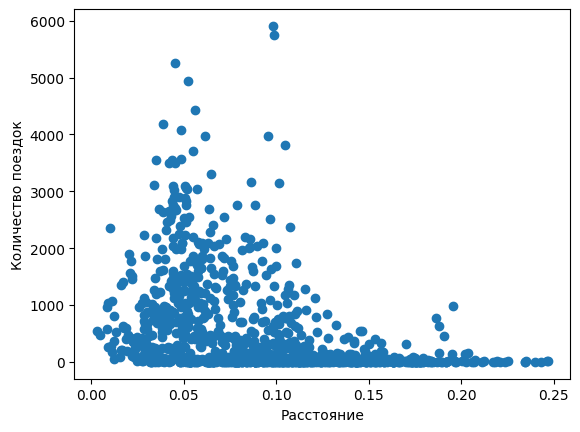

In [89]:
plt.scatter(stations['distance'], stations['id'])
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')

Как видно по графику, количество точек смещено вправо, а из этого исходит, что гипотеза подтверждается

Посмотрим на карте на самые непопулярные и популярные станции на карте, чтобы убедиться в верности гипотезы

In [90]:
temp = stations
stations = stations.loc[stations['id'] == 1]
stations = stations[['startlat', 'startlng', 'meanlat', 'meanlng']]
stations['lng-lat'] = stations['startlng'].astype(str) + ',' + stations['startlat'].astype(str)
stations = stations[['meanlat', 'meanlng', 'lng-lat']]

In [91]:
API_SERVER = "http://static-maps.yandex.ru/1.x"


def set_request(stations):
    params = {"ll": ",".join([str(round(stations['meanlng'].tolist()[0], 2)), str(round(stations['meanlat'].tolist()[0], 2))]),
              "spn": "0.4,0.4",
              "l": 'map'}
    params['pt'] = '~'.join(stations['lng-lat'].tolist())
    image = requests.get(API_SERVER, params)
    with open('data/map.png', "wb") as file:
        file.write(image.content)

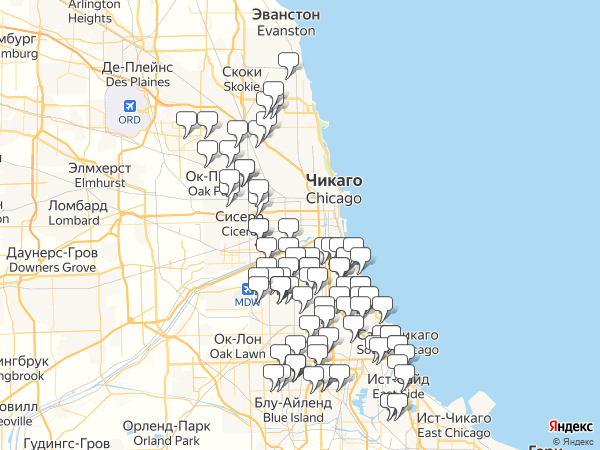

In [92]:
set_request(stations)
Image(filename='data/map.png')

Как мы видим, наименее популярные станции расположены в отдалении от центра города

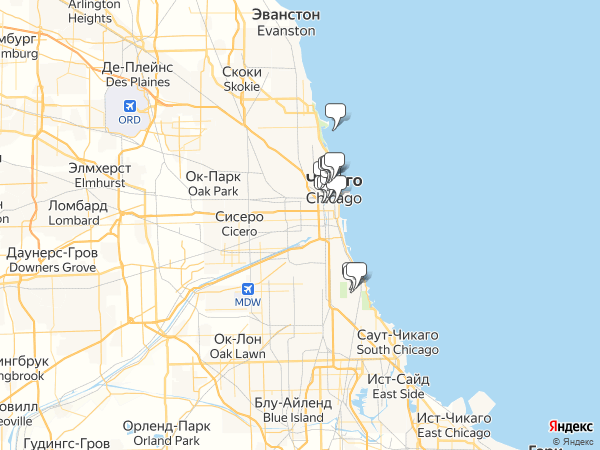

In [93]:
stations = temp
stations = stations.loc[stations['id'] >= 3500]
stations = stations[['startlat', 'startlng', 'meanlat', 'meanlng']]
stations['lng-lat'] = stations['startlng'].astype(str) + ',' + stations['startlat'].astype(str)
stations = stations[['meanlat', 'meanlng', 'lng-lat']]
set_request(stations)
from IPython.display import Image
Image(filename='data/map.png')

Как мы видим, наиболее популярные станции расположены в центре города, а также в парковых зонах

Теперь посмотрим на то, как распределяются велосипеды на станциях. Если где-то будет наблюдаться сильный прирост, а на других - снижение, то мы будем уже говорить о том, что необходимо нанимать людей, которые будут перегонять велосипеды от одних станций к другим

In [94]:
stations = df[['startstation', 'id', 'endstation']].dropna()
stations_start = stations[['startstation', 'id']].rename(columns={'id': 'count'}).groupby(by=['startstation']).count()
stations_end = stations[['endstation', 'id']].rename(columns={'id': 'count'}).groupby(by=['endstation']).count()
count = stations_start - stations_end
count = count.dropna()

In [95]:
count.sort_values('count')

,count
Green St & Randolph St*,-594.0
Sangamon St & Lake St,-406.0
St. Clair St & Erie St,-303.0
Clinton St & Madison St,-266.0
Clinton St & Washington Blvd,-237.0
...,...
Carpenter St & Huron St,343.0
Wells St & Huron St,369.0
Desplaines St & Kinzie St,388.0
Columbus Dr & Randolph St,406.0


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   2.,   0.,   2.,   3.,   7.,   5.,
          4.,  21.,  33.,  44.,  98., 556., 112.,  35.,  20.,  10.,  11.,
          7.,   2.,   4.,   3.,   3.,   2.,   1.,   1.,   0.,   3.,   2.,
          1.,   1.,   1.,   0.,   0.,   1.]),
 array([-594.  , -572.48, -550.96, -529.44, -507.92, -486.4 , -464.88,
        -443.36, -421.84, -400.32, -378.8 , -357.28, -335.76, -314.24,
        -292.72, -271.2 , -249.68, -228.16, -206.64, -185.12, -163.6 ,
        -142.08, -120.56,  -99.04,  -77.52,  -56.  ,  -34.48,  -12.96,
           8.56,   30.08,   51.6 ,   73.12,   94.64,  116.16,  137.68,
         159.2 ,  180.72,  202.24,  223.76,  245.28,  266.8 ,  288.32,
         309.84,  331.36,  352.88,  374.4 ,  395.92,  417.44,  438.96,
         460.48,  482.  ]),
 <BarContainer object of 50 artists>)

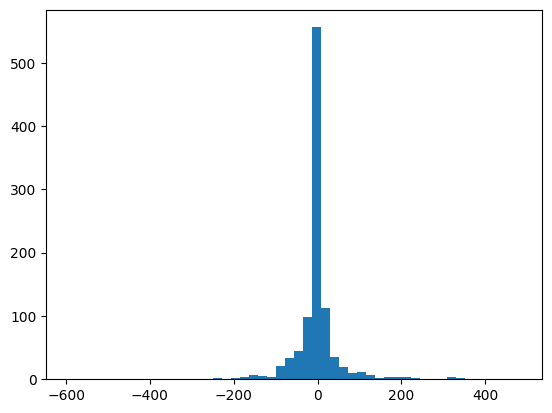

In [96]:
plt.hist(count['count'], bins=50)

Как мы видим, часто станции выходят в 0 по данному параметру, однако потребность в людях все еще существует, т.к. разница может быть слишком большой

### Экономика

**Основные источники доходов**: единоразовая аренда велосипеда, подписка (о последнем данных нет)


**Основные источники расходов**: затраты на покупку новых велосипедов, ремонт + стоимость станций

**Расходы**

**Средние расходы на ремонт в год (начиная с шестого года работы):** 12888 долларов


**Средние расходы на закупку новых велосипедов в год:** 1677857 долларов


**Стоимость станций (в которых мы уверены в 2023 году):** 1102 (станций) * 10000 (долларов за станцию) = 11020000 долларов

**Итого:** 12710745 долларов

**Доходы**


**С единоразовой аренды:** 22780302 долларов


**С подписки:** точно определить нельзя, т.к. требуется информация о каждом отдельном пользователе и типе подписки


**Итого:** 22780302 доллара

**Дополнительно**

Необходимы люди, которые будут заниматься перегоном велосипедов с одних станций к другим (указаны в пункте Станции)

**Источники:**
* https://divvybikes.com/pricing
* https://velomasterclass.ru/dolgovechnost-velosipeda/
* https://kmk45.ru/product/veloparkovka-s-navesom-pergoloy-raduga?utm_referrer=https%3A%2F%2Fyandex.ru%2Fproducts%2Fsearch%3Ftext%3D%25D0%25BA%25D1%2583%25D0%25BF%25D0%25B8%25D1%2582%25D1%258C%2520%25D0%25B2%25D0%25B5%25D0%25BB%25D0%25BE%25D0%25BF%25D0%25B0%25D1%2580%25D0%25BA%25D0%25BE%25D0%25B2%25D0%25BA%25D1%2583
* https://bikehike.org/how-much-does-it-cost-to-repair-disc-bike/#How_much_do_bike_repairs_typically_cost
* https://bicyclevolt.com/electric-bike-maintenance-cost/#:~:text=the%20battery%20life-,Mechanical%20Maintenance%20cost,bring%20this%20cost%20down%20considerably.

### Портрет целевой аудитории

**Возраст:** первично - 20-40 лет, вторично - 40-65 лет

**Членство:** в основном члены (в "экстремальных ситуациях" нужно адаптироваться под рост количества нечленов)

**Популярность байков:** классические и электрические (последние получили пальму первенства)

**Пол:** мужской

**Предпочтение в длительности поездки:** меньше 15 минут (есть исключения в дни, когда проходят различные мероприятия)

**Время поездки:** в районе 14 часов

**Популярность прогулочных сессий:** меньше 10% (в "экстремальных ситуациях" может быть и больше)

### Вывод по станциям

**Зависимость популярности станции от ее дистанции:** чем больше расстояние от центрального положения, тем меньше меньше популярность (есть исключения для особых зон)

**Зависимость популярности от зоны:** наибольшую популярность имеют станции в центре города и парковых зонах

**Существуют станции, которые больше принимают велосипедов, чем отдают (и наоборот)**

**На популярных станциях часто берут классические велосипеды, на менее популярных - электрические**

**Наиболее прибыльные станции:**
* Michigan Ave & Lake St 
* Wells St & Concord Ln 
* Clark St & Elm St
* Shedd Aquarium
* Clinton St & Washington Blvd
* Millennium Park
* Michigan Ave & 8th St
* Streeter Dr & Grand Ave
* DuSable Lake Shore Dr & Monroe St
* Wabash Ave & Grand Ave

## Заключение

Нами был проанализирован велопрокат в городе Чикаго. Мы смогли получить информацию о следующих составляющих этого бизнеса:
1. Экономика станций и байкой;
2. Мы получили информацию о целевой аудитории бизнеса велопроката;
3. Мы смогли определить где и как должны быть расположены станции;
4. Сделали основные выводы, которые определяют результаты работы команды

Что можно было бы сделать еще?
Всегда можно углубиться в исследуемый вопрос, мы показали лишь поверхностно основные тенденции развития велопроката, каким он представлен на данный момент.
Также можно было бы улучшить экономику, если определить некий "физический фонд", в котором бы собирали стоимости буквально каждой станции и велосипеда, однако разрозненность данных усложняет этот процесс